<a href="https://colab.research.google.com/github/amrit-lal-singh/ML-Dl/blob/main/Unet-Large-Image-Semantic-Segmentation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np
import pandas as pd 
import pandas as pd 
import matplotlib.pyplot as plt
import cv2 
import os
from tensorflow.keras.utils import Sequence, to_categorical, plot_model
from keras.layers import Conv2D, Dropout, MaxPooling2D, UpSampling2D, concatenate, Input
from keras.models import Model
from sklearn.model_selection import train_test_split
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping



In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


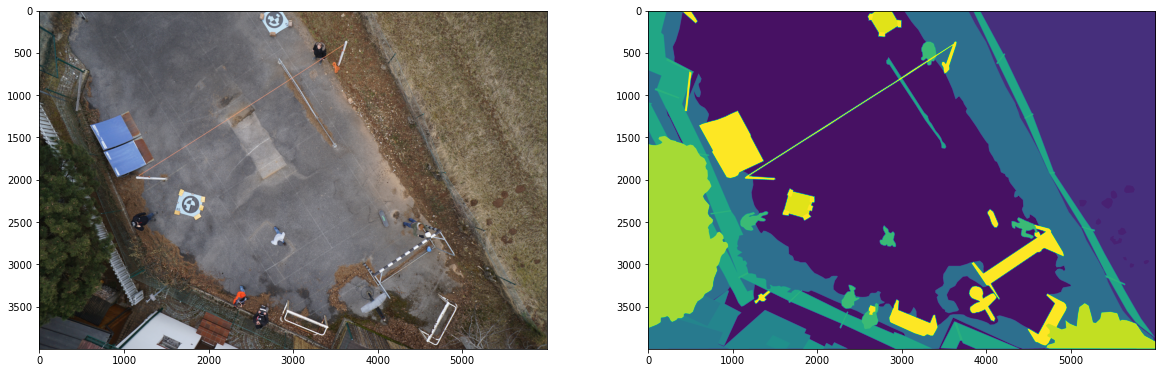

In [3]:
path = '/content/drive/MyDrive/archive/dataset/semantic_drone_dataset/'
img = cv2.imread(path+'original_images/001.jpg')
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
mask = cv2.imread(path + 'label_images_semantic/001.png', cv2.IMREAD_GRAYSCALE)
fig, axis = plt.subplots(1,2,figsize=(20, 10))

axis[0].imshow(img)
axis[1].imshow(mask)

In [4]:
print(img.shape)

(4000, 6000, 3)


In [5]:
X  = []
i = 0
for filename in sorted(os.listdir(path + 'original_images/')):
  a = cv2.imread(path + 'original_images/'+ filename)
  a = cv2.cvtColor(a, cv2.COLOR_BGR2RGB)
  a = cv2.resize(a, (256,256))
  a = a / 255
  X.append(a)
  i+=1
  if i>40:
    break

In [6]:
print(type(X))

<class 'list'>


In [7]:
X = np.array(X)

In [8]:
i = 0
Y = [] 
for filename in sorted(os.listdir(path + 'label_images_semantic/')):
  a = cv2.imread(path + 'label_images_semantic/'+ filename, cv2.IMREAD_GRAYSCALE)
  a = cv2.resize(a, (256,256))
  Y.append(a)
  i+=1
  if i>40:
    break  

Y = np.array(Y)
Yc = to_categorical(Y) #converts to one hot vector



(41, 256, 256, 3)
(41, 256, 256, 23)


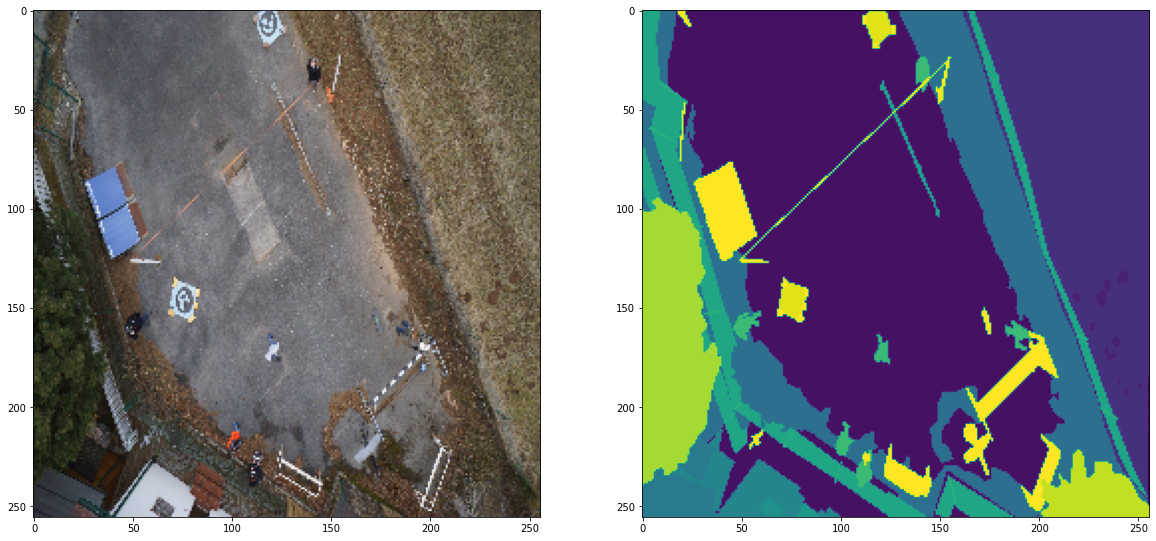

In [9]:
print(X.shape)
print(Yc.shape)
fig, axis = plt.subplots(1, 2, figsize=(20,10))
axis[0].imshow(X[1])
axis[1].imshow(Y[1])

In [10]:
test_image1 = X[-1]
test_label1 = Yc[-1]
test_image2 = X[-2]
test_label2 = Yc[-2]
x_tr, x_val, y_tr, y_val = train_test_split(X[0:40], Yc[0:40], test_size = 0.1)

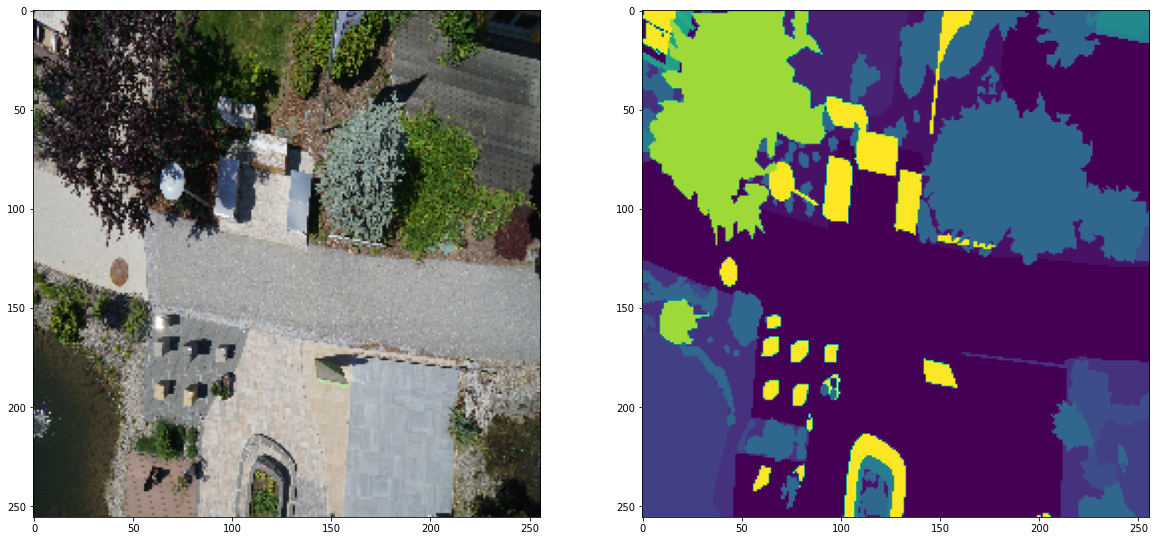

In [11]:
fig, axis = plt.subplots(1, 2, figsize=(20, 10))
axis[0].imshow(x_tr[5])
axis[1].imshow(np.argmax(y_tr[5], axis=2))

U-Net

Developed foe medical field in order to recognise and localise; segment.
It contains only convolutional layers and no fully connected layers.

The feature maps during encoding are also an input to the decoding layers.
To upsample, 2X2 transposed convolutions or deconvolutions are used.



In [12]:
def unet(num_classes = 23, image_shape = (256, 256, 3)):
    # Input
    inputs = Input(image_shape)
    # Encoder Path
    conv1 = Conv2D(64, 3, activation='relu', kernel_initializer = 'he_normal', padding='same')(inputs)
    conv1 = Conv2D(64, 3, activation='relu', kernel_initializer = 'he_normal', padding='same')(conv1)
    pool1 = MaxPooling2D((2,2))(conv1)
    
    conv2 = Conv2D(128, 3, activation='relu', kernel_initializer = 'he_normal', padding='same')(pool1)
    conv2 = Conv2D(128, 3, activation='relu', kernel_initializer = 'he_normal', padding='same')(conv2)
    pool2 = MaxPooling2D((2,2))(conv2)

    conv3 = Conv2D(256, 3, activation='relu', kernel_initializer = 'he_normal', padding='same')(pool2)
    conv3 = Conv2D(256, 3, activation='relu', kernel_initializer = 'he_normal', padding='same')(conv3)
    pool3 = MaxPooling2D((2,2))(conv3)
    
    conv4 = Conv2D(512, 3, activation='relu', kernel_initializer = 'he_normal', padding='same')(pool3)
    conv4 = Conv2D(512, 3, activation='relu', kernel_initializer = 'he_normal', padding='same')(conv4)
    drop4 = Dropout(0.5)(conv4)
    pool4 = MaxPooling2D((2,2))(drop4)
    
    conv5 = Conv2D(1024, 3, activation='relu', kernel_initializer = 'he_normal', padding='same')(pool4)
    conv5 = Conv2D(1024, 3, activation='relu', kernel_initializer = 'he_normal', padding='same')(conv5)
    drop5 = Dropout(0.5)(conv5)
    
    # Decoder Path
    up6 = Conv2D(512, 2, activation='relu', kernel_initializer='he_normal', padding='same')(UpSampling2D(size=(2,2))(drop5))
    merge6 = concatenate([up6, conv4], axis = 3)
    conv6 = Conv2D(512, 3, activation='relu', kernel_initializer='he_normal', padding='same')(merge6)
    conv6 = Conv2D(512, 3, activation='relu', kernel_initializer='he_normal', padding='same')(conv6)
    
    up7 = Conv2D(256, 2, activation='relu', kernel_initializer='he_normal', padding='same')(UpSampling2D(size=(2,2))(conv6))
    merge7 = concatenate([up7, conv3], axis = 3)
    conv7 = Conv2D(256, 3, activation='relu', kernel_initializer='he_normal', padding='same')(merge7)
    conv7 = Conv2D(256, 3, activation='relu', kernel_initializer='he_normal', padding='same')(conv7)
    
    up8 = Conv2D(128, 2, activation='relu', kernel_initializer='he_normal', padding='same')(UpSampling2D(size=(2,2))(conv7))
    merge8 = concatenate([up8, conv2], axis = 3)
    conv8 = Conv2D(128, 3, activation='relu', kernel_initializer='he_normal', padding='same')(merge8)
    conv8 = Conv2D(128, 3, activation='relu', kernel_initializer='he_normal', padding='same')(conv8)
    
    up9 = Conv2D(64, 2, activation='relu', kernel_initializer='he_normal', padding='same')(UpSampling2D(size=(2,2))(conv8))
    merge9 = concatenate([up9, conv1], axis = 3)
    conv9 = Conv2D(64, 3, activation='relu', kernel_initializer='he_normal', padding='same')(merge9)
    conv9 = Conv2D(64, 3, activation='relu', kernel_initializer='he_normal', padding='same')(conv9)
    
    conv10 = Conv2D(num_classes, (1, 1), padding='same', activation='softmax')(conv9)
    
    model = Model(inputs, conv10)
    
    return model

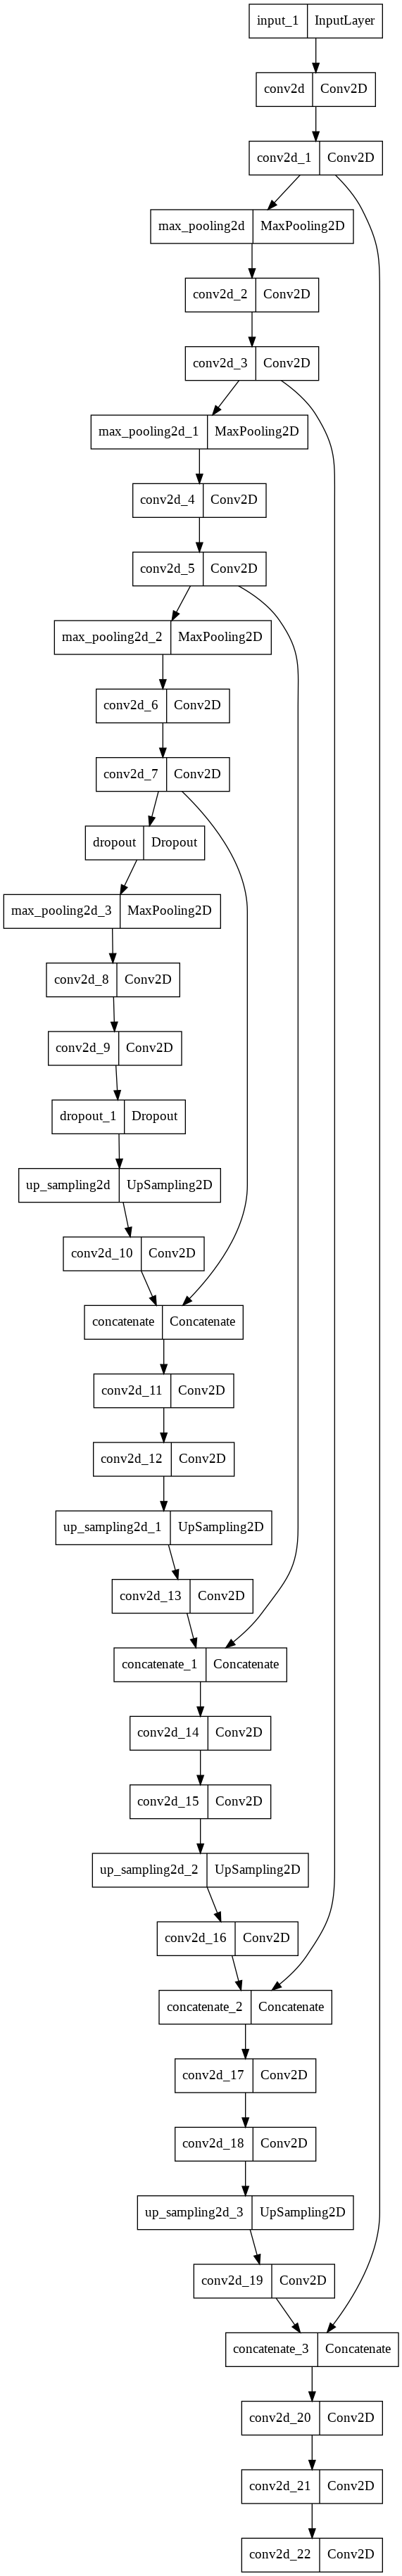

In [13]:
model = unet()
plot_model(model)

In [14]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 256, 256, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 256, 256, 64  1792        ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 conv2d_1 (Conv2D)              (None, 256, 256, 64  36928       ['conv2d[0][0]']                 
                                )                                                             

In [15]:
model_checkpoint = ModelCheckpoint('unet_model.hdf5', monitor='val_loss', verbose=1, save_best_only=True)
model_earlyStopping = EarlyStopping(min_delta= 0.001, patience=30)

model.compile(optimizer='adam', loss=['categorical_crossentropy'], metrics=['accuracy'])

history = model.fit(x=x_tr, y=y_tr,
              validation_data=(x_val, y_val),
              batch_size=16, epochs=10,
              callbacks=[model_checkpoint, model_earlyStopping])

Epoch 1/10
3/3 [==============================] - ETA: 0s - loss: 284.1508 - accuracy: 0.1852  
Epoch 1: val_loss improved from inf to 2.83743, saving model to unet_model.hdf5
3/3 [==============================] - 267s 75s/step - loss: 284.1508 - accuracy: 0.1852 - val_loss: 2.8374 - val_accuracy: 0.4168
Epoch 2/10
3/3 [==============================] - ETA: 0s - loss: 2.7139 - accuracy: 0.3895  
Epoch 2: val_loss improved from 2.83743 to 2.66712, saving model to unet_model.hdf5
3/3 [==============================] - 252s 72s/step - loss: 2.7139 - accuracy: 0.3895 - val_loss: 2.6671 - val_accuracy: 0.4224
Epoch 3/10
3/3 [==============================] - ETA: 0s - loss: 2.4293 - accuracy: 0.4097  
Epoch 3: val_loss did not improve from 2.66712
3/3 [==============================] - 257s 74s/step - loss: 2.4293 - accuracy: 0.4097 - val_loss: 2.7003 - val_accuracy: 0.4245
Epoch 4/10
3/3 [==============================] - ETA: 0s - loss: 2.2787 - accuracy: 0.4116  
Epoch 4: val_loss did 

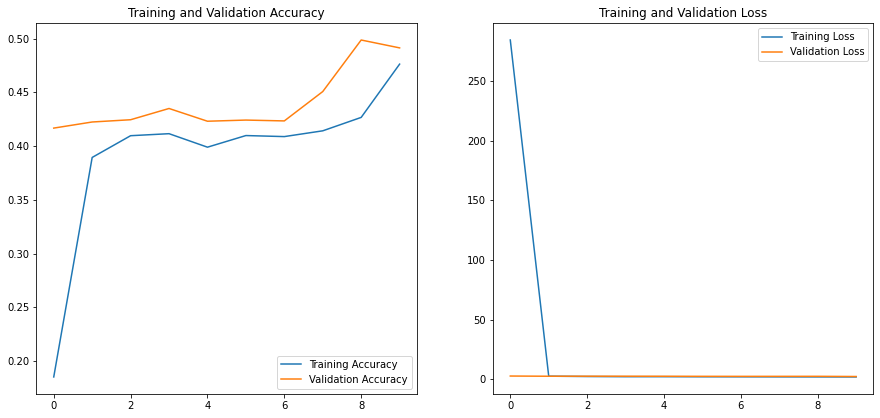

In [16]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs_range = range(len(acc))

plt.figure(figsize=(15, 15))
plt.subplot(2, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(2, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

m1 = test_image1
pred = model.predict(np.expand_dims(m1, 0))
pred_mask = np.argmax(pred, axis=-1)
print(pred_mask.shape)
pred_mask = pred_mask[0]
print(pred_mask.shape)

m2 = test_image2
pred2 = model.predict(np.expand_dims(m2, 0))
pred_mask2 = np.argmax(pred2, axis=-1)
print(pred_mask2.shape)
pred_mask2 = pred_mask2[0]
print(pred_mask2.shape)

Text(0.5, 1.0, 'Prediction')

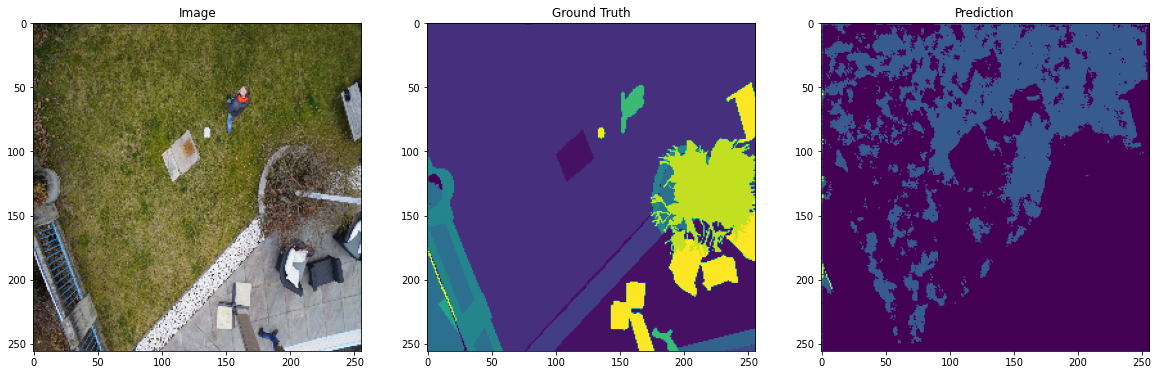

In [18]:
fig, axs = plt.subplots(1, 3, figsize=(20, 10))
axs[0].imshow(m1)
axs[0].set_title('Image')
axs[1].imshow(np.argmax(test_label1, axis=-1))
axs[1].set_title('Ground Truth')
axs[2].imshow(pred_mask)
axs[2].set_title('Prediction')

Text(0.5, 1.0, 'Prediction')

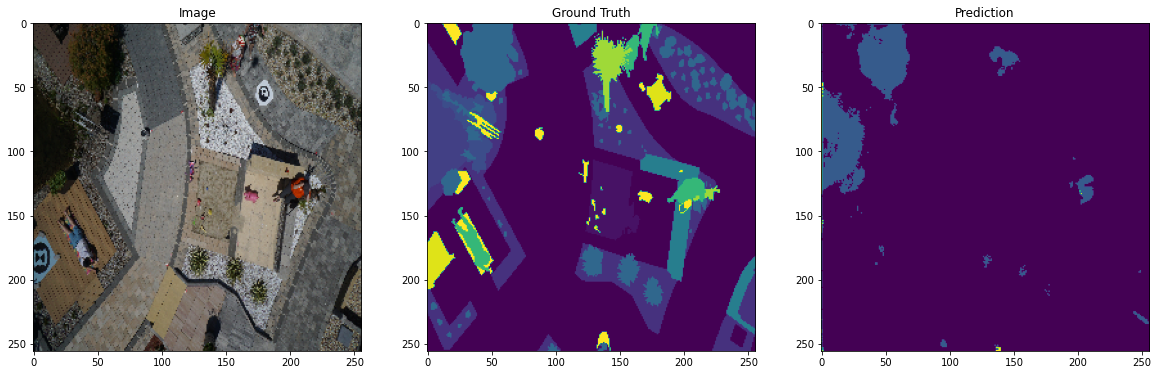

In [19]:
fig, axs = plt.subplots(1, 3, figsize=(20, 10))
axs[0].imshow(m2)
axs[0].set_title('Image')
axs[1].imshow(np.argmax(test_label2, axis=-1))
axs[1].set_title('Ground Truth')
axs[2].imshow(pred_mask2)
axs[2].set_title('Prediction')


In [20]:
model.save("Unet-Large-Image-Semantic-Segmentation.h5")